In [18]:
%load_ext autoreload
%autoreload 2

from utils import *
import numpy as np
import pandas as pd
import sys
sys.path.append("..")

from torch.utils import data

import glob
import random
import os
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from bokeh.io import push_notebook, show, output_notebook,reset_output
from bokeh.plotting import figure
import networkx as nx
from bokeh.plotting import figure, from_networkx, curdoc
from bokeh.models import Rect, HoverTool,  TextInput, GraphRenderer, Circle
from bokeh.io import output_file
from bokeh.plotting import figure, output_file, save
from bokeh.models import (BoxZoomTool, Circle, Line, HoverTool,
                          MultiLine, Plot, Range1d, ResetTool)
from bokeh.models import LinearColorMapper, BasicTicker, ColorBar,CustomJSHover,CustomJS
from bokeh.models import Ellipse, GraphRenderer, StaticLayoutProvider

import grandalf

output_notebook()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
QDIR = os.path.join("/Users/pari/LatencyCollector/queries")
JOB_QNAMES = get_qnames(os.path.join(QDIR, "job"))
CEB_QNAMES = get_qnames(os.path.join(QDIR, "ceb-small"))
ERG_QNAMES = get_qnames(os.path.join(QDIR, "ergast-small"))
STATS_QNAMES = get_qnames(os.path.join(QDIR, "stats"))
JOBLT_QNAMES = get_qnames(os.path.join(QDIR, "joblight_train"))
STACK_QNAMES = get_qnames(os.path.join(QDIR, "stack-small"))
TPCH_QNAMES = get_qnames(os.path.join(QDIR, "tpch"))
ACC_QNAMES = get_qnames(os.path.join(QDIR, "accidents"))

LT_FN = "lt_instances.txt"

#EXP_NAMES = ["exp14_single_stack"]

#EXP_NAMES = ["exp-debug2"]

EXP_NAMES = ["exp1_n2"]
#EXP_NAMES = ["exp3_accidents_n2"]

#EXP_NAMES = ["exp6_multi4b"]

#EXP_NAMES = ["exp1_single", "exp2_single", "exp3_single"]
#EXP_NAMES = ["exp3_single"]


#EXP_NAMES = ["exp1-imdb-n2"]
#EXP_NAMES = ["exp2-imdb-n8"]

#EXP_NAMES = ["exp8_single_stack"]
#EXP_NAMES = ["exp5_single_stats"]
#EXP_NAMES = ["exp6_single_joblight"]
#EXP_NAMES = ["exp7_single_ceb2"]
#EXP_NAMES = ["exp13_imdb"]
#EXP_NAMES = ["exp4_single_ergast"]
#EXP_NAMES = ["exp9_single_tpch"]

#RESULTDIR = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", EXP_NAME)

LT_TYPES = '''a1_large_mag_4g=lt-0d15fb8f5bbe9a27d
a1_large_gp3_4g=lt-04840b55d3f795395
r7g_large_gp2_16g=lt-0212ec953ba35b176
t3_large_gp2_8g=lt-05d2d354bc3dd9133
c5a_large_mag_4g=lt-03218e9e27718bbbe
m6a_large_mag_8g=lt-0f6f46002652f9a4c
t3a_medium_gp3_4g=lt-0af65294350b1a8c1
t3a_large_gp3_8g=lt-084bfbae110d52d4e
r6a_large_mag_16g=lt-0e608666ff3adff07
t4g_large_mag_8g=lt-04e0b4826c63bfadb
c7g_large_mag_4g=lt-0af47c6caa3b53b8b
r7g_medium_gp2_16g=lt-01d0081183a7d79f2
t3_xlarge_gp2_16g=lt-0b413bcc22b3ac8fb
'''

lt_types = pd.read_csv(StringIO(LT_TYPES), sep="=", header=None, 
                       names=["lt_type", "lt"])
# ltdf = pd.read_csv(os.path.join(RESULTDIR, LT_FN), header=None, 
#                    names=["instance", "lt"])
# ltdf = ltdf.merge(lt_types, on="lt")
# ltdf

In [46]:
# print(os.path.exists(RESULTDIR))

dfs = []
for exp in EXP_NAMES:
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "duckdb", "concurrent", exp)
    #resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "duckdb", exp)
    
    print(resultdir)
    assert os.path.exists(resultdir)
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
                   names=["instance", "lt"],
                      
                      )
    ltdf = ltdf.merge(lt_types, on="lt")
    
    rtfns = glob.iglob(resultdir + "/*/results/Runtime*.csv")

    for rtfn in rtfns:
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(rtfn)))
        rt = pd.read_csv(rtfn, on_bad_lines="skip")
        rt["instance"] = instance_name
        rt = rt.merge(ltdf, on="instance")
        if len(rt) == 0:
            print(instance_name)
            continue
        mintime = min(rt["start_time"].values)
        rt["relative_start_time"] = rt.apply(lambda x: x["start_time"]-mintime , axis=1)

        dfs.append(rt)
    
df = pd.concat(dfs)

/Users/pari/prism-testbed/LatencyCollectorResults/duckdb/concurrent/exp1_n2


In [47]:
print(df["runtime"].sum())
print(df["runtime"].describe())
print(df.keys())

44512.74991822243
count    4222.000000
mean       10.543048
std        56.050457
min         0.791821
25%         2.376707
50%         4.808428
75%         9.536691
max      3315.619080
Name: runtime, dtype: float64
Index(['start_time', 'qname', 'runtime', 'exp_analyze', 'samples_type',
       'num_processes', 'parallel_workers', 'no_index', 'drop_cache',
       'result_dir', 'query_dir', 'dbms', 'cost_model', 'materialize',
       'explain', 'reps', 'num_queries', 'timeout', 'rerun_timeouts',
       'db_name', 'db_host', 'user', 'pwd', 'port', 'instance', 'lt',
       'lt_type', 'relative_start_time', 'col_store'],
      dtype='object')


In [48]:
#df = df[df["lt_type"] != "a1_large_mag_4g"]
df = df[df["runtime"] >= 0.0]
#df = df[~df["qname"].str.contains("credit")]
#df = df[df["qname"].str.contains("walmart")]

In [49]:
print(len(df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99])))
df.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99]).round(2)

9


,count,mean,std,min,50%,90%,99%,max
lt_type,,,,,,,,
c5a_large_mag_4g,162.0,35.93,260.32,0.99,5.57,59.44,112.64,3315.62
c7g_large_mag_4g,515.0,10.85,52.36,0.81,4.20,19.71,81.02,1148.91
m6a_large_mag_8g,543.0,10.10,16.64,0.81,4.49,25.77,82.82,137.93
r6a_large_mag_16g,571.0,5.41,7.75,0.79,3.57,9.06,44.98,84.26
r7g_large_gp2_16g,573.0,5.14,7.02,0.81,3.40,8.73,31.93,79.22
t3_large_gp2_8g,540.0,9.48,12.53,1.30,5.72,18.77,63.95,145.59
t3_xlarge_gp2_16g,526.0,9.49,12.90,1.26,5.83,17.99,72.04,133.46
t3a_medium_gp3_4g,455.0,12.65,22.44,1.63,7.23,22.82,97.73,331.36
t4g_large_mag_8g,337.0,16.96,22.81,1.27,9.12,40.17,122.08,151.00


In [51]:
cebdf = df[df["query_dir"].str.contains("ceb")]
cebdf.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99]).round(2)

,count,mean,std,min,50%,90%,99%,max
lt_type,,,,,,,,
c5a_large_mag_4g,162.0,35.93,260.32,0.99,5.57,59.44,112.64,3315.62
c7g_large_mag_4g,515.0,10.85,52.36,0.81,4.20,19.71,81.02,1148.91
m6a_large_mag_8g,543.0,10.10,16.64,0.81,4.49,25.77,82.82,137.93
r6a_large_mag_16g,571.0,5.41,7.75,0.79,3.57,9.06,44.98,84.26
r7g_large_gp2_16g,573.0,5.14,7.02,0.81,3.40,8.73,31.93,79.22
t3_large_gp2_8g,540.0,9.48,12.53,1.30,5.72,18.77,63.95,145.59
t3_xlarge_gp2_16g,526.0,9.49,12.90,1.26,5.83,17.99,72.04,133.46
t3a_medium_gp3_4g,455.0,12.65,22.44,1.63,7.23,22.82,97.73,331.36
t4g_large_mag_8g,337.0,16.96,22.81,1.27,9.12,40.17,122.08,151.00


In [26]:
len(set(df["qname"]))

949

In [27]:
#df = pd.DataFrame(data)

# Group by 'tag', 'lt_type', and 'query', then calculate standard deviation for 'runtime'
std_per_group = df.groupby(['query_dir', 'lt_type', 'qname'])['runtime'].std()

# For each 'tag', calculate the average of these standard deviations
average_std_per_tag = std_per_group.groupby('query_dir').mean()

# Converting the Series to a DataFrame for better table formatting
average_std_table = average_std_per_tag.reset_index()
average_std_table.columns = ['Tag', 'Average_Std']

average_std_table


,Tag,Average_Std
0,./queries/accidents,77.013004
1,./queries/basketball,NaN
2,./queries/ccs,6.650073
3,./queries/ceb-small,17.250090
4,./queries/credit,NaN
5,./queries/financial,4.257223
6,./queries/ssb,3.072316


In [29]:
len(set(df["qname"]))

949

In [30]:
exp_plan_str = df["exp_analyze"].values[0]

In [31]:
exp_plan_str

'[(\'analyzed_plan\', \'{\\n   "name":  "Query", \\n   "result": 3.729370,\\n   "timing": 3.729377,\\n   "cardinality": 0,\\n   "extra-info": "explain analyze SELECT SUM(\\\\"oseba\\\\".\\\\"spol\\\\" + \\\\"nesreca\\\\".\\\\"upravna_enota\\\\") as agg_0, MIN(\\\\"upravna_enota\\\\".\\\\"povrsina\\\\" + \\\\"oseba\\\\".\\\\"id_nesreca\\\\") as agg_1 FROM \\\\"oseba\\\\" LEFT OUTER JOIN \\\\"nesreca\\\\" ON \\\\"oseba\\\\".\\\\"id_nesreca\\\\" = \\\\"nesreca\\\\".\\\\"id_nesreca\\\\" LEFT OUTER JOIN \\\\"upravna_enota\\\\" ON \\\\"oseba\\\\".\\\\"upravna_enota\\\\" = \\\\"upravna_enota\\\\".\\\\"id_upravna_enota\\\\"  WHERE \\\\"upravna_enota\\\\".\\\\"st_prebivalcev\\\\" >= 188593 AND \\\\"oseba\\\\".\\\\"vrsta_udelezenca\\\\" = \\\'PE\\\' AND \\\\"upravna_enota\\\\".\\\\"ime_upravna_enota\\\\" NOT LIKE \\\'%o%b%\\\'", \\n   "timings": [\\n\\n   ],\\n   "children": [\\n    {\\n      "name": "EXPLAIN_ANALYZE",\\n      "timing":0.000000,\\n      "cardinality":0,\\n      "extra_info": "",

In [32]:
import json
import networkx as nx

def add_nodes_from_json(graph, json_node, parent=None):
    """ Recursively add nodes and edges from a JSON node to a NetworkX graph. """
    
    node_type = json_node.get("name", "Unknown")
    node_name = json_node.get("name", "Unknown") + "_" + str(random.randint(0, 9999))

    einfo = json_node["extra_info"]
    einfo = einfo.split("[INFOSEPARATOR]")
    
    print("adding node: ", node_name)
   
    graph.add_node(node_name)
    graph.nodes[node_name]["NodeType"] = node_type
    
    #print(einfo)
    for curinfo in einfo:
        if "EC" in curinfo:
            curinfo = curinfo.split("\n")
            print(curinfo)
            ec = curinfo[1]
            ecard = float(ec[ec.find(" "):])
            print(ecard)
            graph.nodes()[node_name]["ExpectedCard"] = ecard
            if len(curinfo) > 2:
                ecost = float(curinfo[2][curinfo[2].find(" "):])
                print(ecost)
                graph.nodes()[node_name]["ExpectedCost"] = ecost
            else:
                graph.nodes()[node_name]["ExpectedCost"] = 0.0
            
        elif "Cost" in curinfo:
            assert False
            print(curinfo)
            print("????")
        else:
            graph.nodes()[node_name]["ExpectedCard"] = 0.0
            graph.nodes()[node_name]["ExpectedCost"] = 0.0
    
    # Add an edge from the parent node, if it exists
    if parent is not None:
        graph.add_edge(parent, node_name)

    # Recursively add child nodes
    for child in json_node.get("children", []):
        add_nodes_from_json(graph, child, node_name)

def create_networkx_graph_from_json(json_blob):
    """ Creates a NetworkX graph from a DuckDB execution plan JSON blob. """
    #json_data = json.loads(json_blob)
    json_data = json.loads(eval(json_blob)[0][1])
    json_data = json_data["children"][0]["children"][0]
    G = nx.DiGraph()
    add_nodes_from_json(G, json_data)
    return G

# Example usage:
# json_blob = '...'  # Your JSON blob here
graph = create_networkx_graph_from_json(exp_plan_str)
# Now, 'graph' is a NetworkX graph representing your execution plan.

adding node:  UNGROUPED_AGGREGATE_772
adding node:  PROJECTION_1481
adding node:  HASH_JOIN_2135
['', 'EC: 9086', 'Cost: 4779266']
9086.0
4779266.0
adding node:  HASH_JOIN_519
['', 'EC: 227152', 'Cost: 4770180']
227152.0
4770180.0
adding node:  SEQ_SCAN _3586
['', 'EC: 0']
0.0
adding node:  SEQ_SCAN _4752
['', 'EC: 0']
0.0
adding node:  PROJECTION_9260
adding node:  FILTER_8905
['', 'EC: 12']
12.0
adding node:  SEQ_SCAN _1324
['', 'EC: 64']
64.0


In [33]:
graph.nodes()

NodeView(('UNGROUPED_AGGREGATE_772', 'PROJECTION_1481', 'HASH_JOIN_2135', 'HASH_JOIN_519', 'SEQ_SCAN _3586', 'SEQ_SCAN _4752', 'PROJECTION_9260', 'FILTER_8905', 'SEQ_SCAN _1324'))

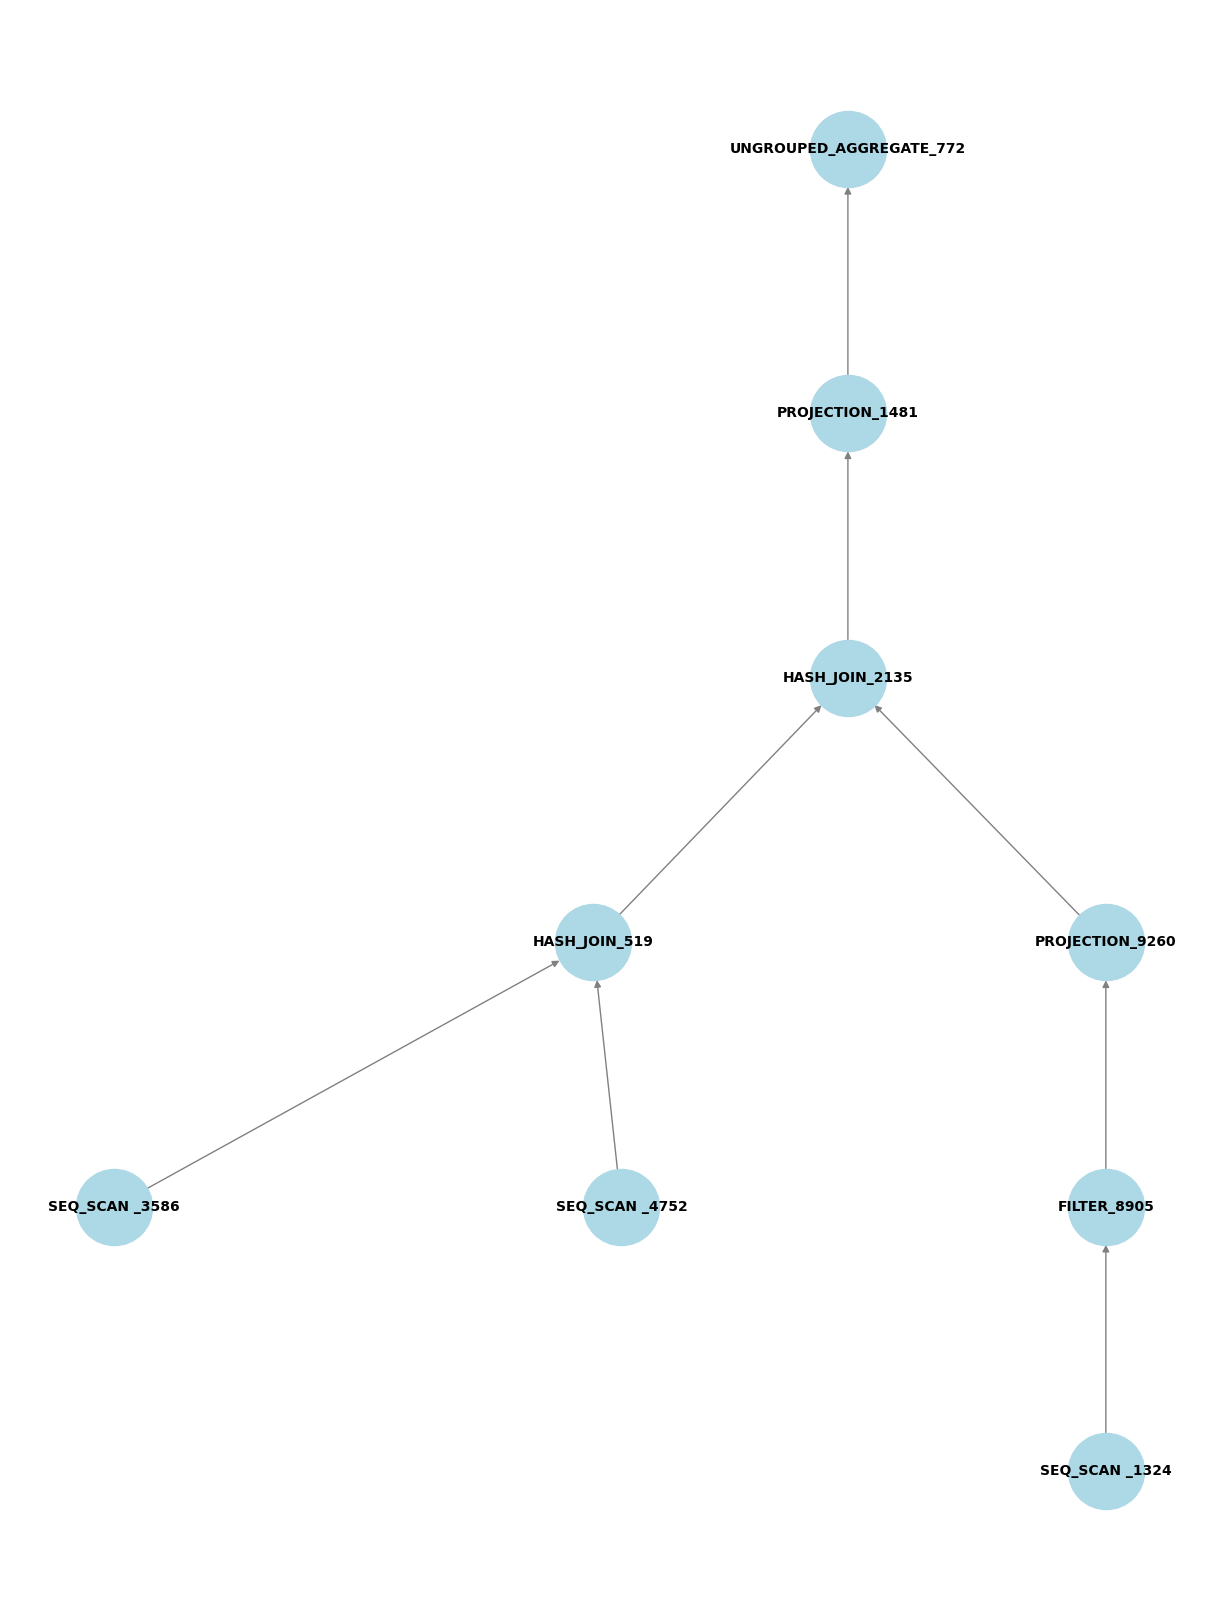

In [34]:
def plot_graph(G):
    # Position nodes using graphviz layout
   # pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
    tmp = nx.Graph()
    for edge in G.edges():
        tmp.add_edge(edge[0], edge[1])
    pos = nx.nx_pydot.graphviz_layout(tmp, prog="dot")

    # Draw the graph
    plt.figure(figsize=(12, 16))  # Set the size of the plot
    
    G = G.reverse()
    nx.draw(G, pos, with_labels=True, arrows=True, node_size=3000, node_color="lightblue", 
            font_size=10, font_weight="bold", edge_color="gray")

    # Show the plot
    plt.show()
    
plot_graph(graph)

In [35]:
exp_plan

NameError: name 'exp_plan' is not defined

In [36]:
exp_plan["children"][0]["children"][0]

NameError: name 'exp_plan' is not defined

In [37]:
eval(exp_plan)

NameError: name 'exp_plan' is not defined

In [38]:
exp_plan["extra-info"]

NameError: name 'exp_plan' is not defined

In [39]:
tmp = df[df["runtime"] < 900.0]
tmp.groupby(["lt_type"])["runtime"].describe(percentiles=[0.90, 0.99]).round(2)

,count,mean,std,min,50%,90%,99%,max
lt_type,,,,,,,,
c7g_large_mag_4g,3476.0,10.40,55.24,0.01,0.90,9.69,286.83,765.86
r6a_large_mag_16g,3940.0,9.43,47.35,0.00,1.23,13.77,187.94,874.80
r7g_large_gp2_16g,3972.0,8.53,50.90,0.01,0.93,10.02,179.24,891.52
t3_large_gp2_8g,3707.0,10.67,40.20,0.01,2.02,22.19,145.32,805.31
t3_xlarge_gp2_16g,3896.0,10.11,52.49,0.01,1.30,16.14,164.47,875.84
t4g_large_mag_8g,3700.0,13.76,60.28,0.01,1.31,23.39,197.29,840.36


In [18]:
LTTYPES = list(set(df["lt_type"]))
LTTYPES.sort()
LTTYPES

['a1_large_gp3_4g',
 'c5a_large_mag_4g',
 'c7g_large_mag_4g',
 'm6a_large_mag_8g',
 'r6a_large_mag_16g',
 'r7g_large_gp2_16g',
 't3_large_gp2_8g',
 't3_xlarge_gp2_16g',
 't3a_medium_gp3_4g',
 't4g_large_mag_8g']

In [19]:
TEST_INSTANCES = ["a1_large_gp3_4g", "c7g_large_mag_4g", "r7g_large_gp2_16g", "t3a_medium_gp3_4g", 
                  "m6a_large_mag_8g", "t4g_large_mag_8g"]

In [20]:
set(df["qname"])

{'00115a785f16c3cc2a3d8dd01cdaacbc1bad7978.sql',
 '006ad3e743b877a991463e0149f02e8c349a3c31.sql',
 '0082f3ed627d38d1dc2d01910f1f5b67cc12b51e.sql',
 '0701574e1eeb73de1f5e67407c2f63eadc8344aa.sql',
 '07c0b3b296bac4c12b2363b47fa23fcfcb26fae9.sql',
 '08eafbdf8f0952a5de815945c7563a0e37aa53c8.sql',
 '0d9fe153613982c6c003f92736280a83b55782d5.sql',
 '0f05350b51ae5ac12ec73d03ceaf618376a9bcbf.sql',
 '11a83131985d2742cb333582ff7317a80fbcb587.sql',
 '130008519a1efd315d28b98b2fe4e71e5c7190c7.sql',
 '134ee2c0fbd159b41c07050c2b59b6cc5c3593b1.sql',
 '162d50b659f6b28462dabb68782720b1b3829a5e.sql',
 '17206e5e52373d88e5618fa92e5dc3f47d0a2df3.sql',
 '17b2f0f8db0541f33501acfac7bc210ed023897c.sql',
 '19cd146e1f13d4ef5e5aeedea48afb20497a844d.sql',
 '1a7ffe741a24cc8409450955a238fb71b2a3a1d3.sql',
 '1cad7ba67ded31b9e21a69986d2bd33796875dc6.sql',
 '1d26ce611ba5722950a983da19c6decf0929f279.sql',
 '1d650516f00c72e90b20c2e41c5567673ccd3432.sql',
 '1ddfbe8498a66c131776e24a7bf732484614d62d.sql',
 '2170d73162a52e8885

In [21]:
tmp = df[df["runtime"] >= 900.0]
print(len(tmp))
print(len(set(tmp["qname"])))
print(set(tmp["qname"]))

334
27
{'4c24e6c5104b55fb1462bc477487f4c8501f66c2.sql', '31788b6ff4949f9b85d924b0c0071be6376bff3f.sql', '11a83131985d2742cb333582ff7317a80fbcb587.sql', '3829863fef44161b35ea87a9ad0542337e82d58b.sql', '644fd2d5572d784ed63d7f4988241903db09a222.sql', '239e59fa33e5545b183a10f23667650c9b14cc54.sql', '3b4a33a113887baad8d24fd4dc8027f2523d1562.sql', '4b4e960f25e9789d517bc544245e4fc5ba2b2a51.sql', '006ad3e743b877a991463e0149f02e8c349a3c31.sql', '2170d73162a52e888591811df3a9a02d19259a32.sql', 'fd79ca7b45968ebb273719f6bc2b07567b2e8f49.sql', '1ddfbe8498a66c131776e24a7bf732484614d62d.sql', '4e64616ac59a77d52d264fe2e561144297139c30.sql', '49d19ecd559c6cbe26a05eea347eb5582740f300.sql', 'fcc1e4325664af606c8c17becab1d26bb2b29c8d.sql', '2b47a010c117af2d865257f2cdccefd84393b167.sql', '2556dfd6a809c58b2e0f10ed9766e2a3678a190d.sql', '17206e5e52373d88e5618fa92e5dc3f47d0a2df3.sql', '134ee2c0fbd159b41c07050c2b59b6cc5c3593b1.sql', 'a0b8a8ac50b14626db66156236f062a186e3678c.sql', '1a7ffe741a24cc8409450955a238fb7

In [22]:
qworkloads = {}
for qname in JOB_QNAMES:
    qworkloads[qname] = "JOB"
for qname in CEB_QNAMES:
    qworkloads[qname] = "CEB"
for qname in ERG_QNAMES:
    qworkloads[qname] = "ErgastF1"
for qname in STATS_QNAMES:
    qworkloads[qname] = "Stats"
for qname in JOBLT_QNAMES:
    qworkloads[qname] = "JOB-LT"
for qname in STACK_QNAMES:
    qworkloads[qname] = "Stack"
for qname in TPCH_QNAMES:
    qworkloads[qname] = "TPCH"
    
df["workload"] = df.apply(lambda x: qworkloads[x["qname"]] , axis=1)

df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

KeyError: '31788b6ff4949f9b85d924b0c0071be6376bff3f.sql'

In [23]:
jdf = df[df["workload"] == "JOB"]
cdf = df[df["workload"] == "CEB"]

jdf.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99]).round(2)

KeyError: 'workload'

In [24]:
df.groupby(["workload", "lt_type"])["runtime"].describe(percentiles=[0.99])

KeyError: 'workload'

In [25]:
# tmp = df.groupby(["lt_type", "qname"])["runtime"].mean().reset_index()
# #tmp
# # dfp = tmp.pivot('lt_type', 'lt_type')
# # dfp.corr()

In [26]:
df.groupby(["qname","lt_type"])["runtime"].describe().sort_values(by="std", ascending=False).head(60)

count  \
qname                                        lt_type                    
006ad3e743b877a991463e0149f02e8c349a3c31.sql m6a_large_mag_8g     3.0   
                                             t4g_large_mag_8g     4.0   
31788b6ff4949f9b85d924b0c0071be6376bff3f.sql t3_large_gp2_8g      9.0   
239e59fa33e5545b183a10f23667650c9b14cc54.sql t4g_large_mag_8g     4.0   
134ee2c0fbd159b41c07050c2b59b6cc5c3593b1.sql t3a_medium_gp3_4g    9.0   
4e64616ac59a77d52d264fe2e561144297139c30.sql r6a_large_mag_16g    8.0   
11a83131985d2742cb333582ff7317a80fbcb587.sql m6a_large_mag_8g     3.0   
4b4e960f25e9789d517bc544245e4fc5ba2b2a51.sql t3_large_gp2_8g      9.0   
2556dfd6a809c58b2e0f10ed9766e2a3678a190d.sql t4g_large_mag_8g     4.0   
1a7ffe741a24cc8409450955a238fb71b2a3a1d3.sql m6a_large_mag_8g     5.0   
17206e5e52373d88e5618fa92e5dc3f47d0a2df3.sql r6a_large_mag_16g    6.0   
1a7ffe741a24cc8409450955a238fb71b2a3a1d3.sql t4g_large_mag_8g     5.0   
3adb27f01b9cb4a801bbe3315a49efceba56b8a1.sql m6a_large_mag_8g     4.0   
f2351bdabd713de95b30d1bf7562188fc796d9e2.sql t3_large_gp2_8g     10.0   
11a83131985d2742cb333582ff7317a80fbcb587.sql t4g_large_mag_8g     5.0   
78cd9a4dc70fa8e23f992a986b4af258c0b2a29d.sql t3_large_gp2_8g      9.0   
239e59fa33e5545b183a10f23667650c9b14cc54.sql m6a_large_mag_8g     4.0   
134ee2c0fbd159b41c07050c2b59b6cc5c3593b1.sql r6a_large_mag_16g    6.0   
78cd9a4dc70fa8e23f992a986b4af258c0b2a29d.sql r7g_large_gp2_16g   13.0   
25377642f94e43939a975e9544c916b1ea6b72c6.sql m6a_large_mag_8g     3.0   
2a2e41559ecc9823f2688b86c188d40c5ff19741.sql m6a_large_mag_8g     3.0   
3829863fef44161b35ea87a9ad0542337e82d58b.sql t3a_medium_gp3_4g   10.0   
25377642f94e43939a975e9544c916b1ea6b72c6.sql t4g_large_mag_8g     4.0   
1a7ffe741a24cc8409450955a238fb71b2a3a1d3.sql r6a_large_mag_16g    6.0   
3adb27f01b9cb4a801bbe3315a49efceba56b8a1.sql t4g_large_mag_8g     5.0   
4e64616ac59a77d52d264fe2e561144297139c30.sql t3_large_gp2_8g     10.0   
4c24e6c5104b55fb1462bc477487f4c8501f66c2.sql t4g_large_mag_8g     4.0   
f2351bdabd713de95b30d1bf7562188fc796d9e2.sql r7g_large_gp2_16g   13.0   
49d19ecd559c6cbe26a05eea347eb5582740f300.sql r6a_large_mag_16g    7.0   
4b4e960f25e9789d517bc544245e4fc5ba2b2a51.sql r7g_large_gp2_16g   13.0   
4c520c9f43febc33412eebb11ab06bf84d652fa6.sql c7g_large_mag_4g     4.0   
0f05350b51ae5ac12ec73d03ceaf618376a9bcbf.sql r6a_large_mag_16g    6.0   
2170d73162a52e888591811df3a9a02d19259a32.sql m6a_large_mag_8g     3.0   
                                             r6a_large_mag_16g    8.0   
2a2e41559ecc9823f2688b86c188d40c5ff19741.sql t4g_large_mag_8g     4.0   
                                             c7g_large_mag_4g     4.0   
2556dfd6a809c58b2e0f10ed9766e2a3678a190d.sql t3_large_gp2_8g      9.0   
134ee2c0fbd159b41c07050c2b59b6cc5c3593b1.sql t3_large_gp2_8g     11.0   
4c520c9f43febc33412eebb11ab06bf84d652fa6.sql c5a_large_mag_4g     3.0   
006ad3e743b877a991463e0149f02e8c349a3c31.sql c5a_large_mag_4g     3.0   
130008519a1efd315d28b98b2fe4e71e5c7190c7.sql m6a_large_mag_8g     3.0   
f2351bdabd713de95b30d1bf7562188fc796d9e2.sql t3_xlarge_gp2_16g   13.0   
2b47a010c117af2d865257f2cdccefd84393b167.sql t3a_medium_gp3_4g   10.0   
4b4e960f25e9789d517bc544245e4fc5ba2b2a51.sql t3a_medium_gp3_4g   10.0   
49d19ecd559c6cbe26a05eea347eb5582740f300.sql t3a_medium_gp3_4g   10.0   
305be8ecb4aa020173bd31e25974b8d24a4f0d97.sql c5a_large_mag_4g     3.0   
4c520c9f43febc33412eebb11ab06bf84d652fa6.sql m6a_large_mag_8g     3.0   
2170d73162a52e888591811df3a9a02d19259a32.sql t4g_large_mag_8g     5.0   
19cd146e1f13d4ef5e5aeedea48afb20497a844d.sql m6a_large_mag_8g     3.0   
2b47a010c117af2d865257f2cdccefd84393b167.sql t4g_large_mag_8g     5.0   
ced7dc1df186ba1745e5c67609bd97b52776aa0f.sql t4g_large_mag_8g     3.0   
3829863fef44161b35ea87a9ad0542337e82d58b.sql t3_large_gp2_8g      9.0   
19cd146e1f13d4ef5e5aeedea48afb20497a844d.sql t4g_large_mag_8g     6.0   
31788b6ff4949f9b85d924b0c0071be6376bff3f.sql t3a_

In [27]:
tmp = df[~df["lt_type"].str.contains("gp2")]
tmp.groupby(["qname","lt_type"])["runtime"].describe().sort_values(by="std", ascending=False).head(60)

count  \
qname                                        lt_type                    
006ad3e743b877a991463e0149f02e8c349a3c31.sql m6a_large_mag_8g     3.0   
                                             t4g_large_mag_8g     4.0   
239e59fa33e5545b183a10f23667650c9b14cc54.sql t4g_large_mag_8g     4.0   
134ee2c0fbd159b41c07050c2b59b6cc5c3593b1.sql t3a_medium_gp3_4g    9.0   
4e64616ac59a77d52d264fe2e561144297139c30.sql r6a_large_mag_16g    8.0   
11a83131985d2742cb333582ff7317a80fbcb587.sql m6a_large_mag_8g     3.0   
2556dfd6a809c58b2e0f10ed9766e2a3678a190d.sql t4g_large_mag_8g     4.0   
1a7ffe741a24cc8409450955a238fb71b2a3a1d3.sql m6a_large_mag_8g     5.0   
17206e5e52373d88e5618fa92e5dc3f47d0a2df3.sql r6a_large_mag_16g    6.0   
1a7ffe741a24cc8409450955a238fb71b2a3a1d3.sql t4g_large_mag_8g     5.0   
3adb27f01b9cb4a801bbe3315a49efceba56b8a1.sql m6a_large_mag_8g     4.0   
11a83131985d2742cb333582ff7317a80fbcb587.sql t4g_large_mag_8g     5.0   
239e59fa33e5545b183a10f23667650c9b14cc54.sql m6a_large_mag_8g     4.0   
134ee2c0fbd159b41c07050c2b59b6cc5c3593b1.sql r6a_large_mag_16g    6.0   
25377642f94e43939a975e9544c916b1ea6b72c6.sql m6a_large_mag_8g     3.0   
2a2e41559ecc9823f2688b86c188d40c5ff19741.sql m6a_large_mag_8g     3.0   
3829863fef44161b35ea87a9ad0542337e82d58b.sql t3a_medium_gp3_4g   10.0   
25377642f94e43939a975e9544c916b1ea6b72c6.sql t4g_large_mag_8g     4.0   
1a7ffe741a24cc8409450955a238fb71b2a3a1d3.sql r6a_large_mag_16g    6.0   
3adb27f01b9cb4a801bbe3315a49efceba56b8a1.sql t4g_large_mag_8g     5.0   
4c24e6c5104b55fb1462bc477487f4c8501f66c2.sql t4g_large_mag_8g     4.0   
49d19ecd559c6cbe26a05eea347eb5582740f300.sql r6a_large_mag_16g    7.0   
4c520c9f43febc33412eebb11ab06bf84d652fa6.sql c7g_large_mag_4g     4.0   
0f05350b51ae5ac12ec73d03ceaf618376a9bcbf.sql r6a_large_mag_16g    6.0   
2170d73162a52e888591811df3a9a02d19259a32.sql m6a_large_mag_8g     3.0   
                                             r6a_large_mag_16g    8.0   
2a2e41559ecc9823f2688b86c188d40c5ff19741.sql t4g_large_mag_8g     4.0   
                                             c7g_large_mag_4g     4.0   
4c520c9f43febc33412eebb11ab06bf84d652fa6.sql c5a_large_mag_4g     3.0   
006ad3e743b877a991463e0149f02e8c349a3c31.sql c5a_large_mag_4g     3.0   
130008519a1efd315d28b98b2fe4e71e5c7190c7.sql m6a_large_mag_8g     3.0   
2b47a010c117af2d865257f2cdccefd84393b167.sql t3a_medium_gp3_4g   10.0   
4b4e960f25e9789d517bc544245e4fc5ba2b2a51.sql t3a_medium_gp3_4g   10.0   
49d19ecd559c6cbe26a05eea347eb5582740f300.sql t3a_medium_gp3_4g   10.0   
305be8ecb4aa020173bd31e25974b8d24a4f0d97.sql c5a_large_mag_4g     3.0   
4c520c9f43febc33412eebb11ab06bf84d652fa6.sql m6a_large_mag_8g     3.0   
2170d73162a52e888591811df3a9a02d19259a32.sql t4g_large_mag_8g     5.0   
19cd146e1f13d4ef5e5aeedea48afb20497a844d.sql m6a_large_mag_8g     3.0   
2b47a010c117af2d865257f2cdccefd84393b167.sql t4g_large_mag_8g     5.0   
ced7dc1df186ba1745e5c67609bd97b52776aa0f.sql t4g_large_mag_8g     3.0   
19cd146e1f13d4ef5e5aeedea48afb20497a844d.sql t4g_large_mag_8g     6.0   
31788b6ff4949f9b85d924b0c0071be6376bff3f.sql t3a_medium_gp3_4g   10.0   
3b4a33a113887baad8d24fd4dc8027f2523d1562.sql r6a_large_mag_16g    8.0   
4dc8bcf9b7c84d46f45ed994fb2db62a33ede2e8.sql t4g_large_mag_8g     4.0   
2a2e41559ecc9823f2688b86c188d40c5ff19741.sql c5a_large_mag_4g     3.0   
1cad7ba67ded31b9e21a69986d2bd33796875dc6.sql c5a_large_mag_4g     2.0   
006ad3e743b877a991463e0149f02e8c349a3c31.sql c7g_large_mag_4g     4.0   
305be8ecb4aa020173bd31e25974b8d24a4f0d97.sql t4g_large_mag_8g     4.0   
3d9d4cac4c2b7ac084aea1cd4cd727ceeee3ef7f.sql m6a_large_mag_8g     4.0   
1ddfbe8498a66c131776e24a7bf732484614d62d.sql r6a_large_mag_16g    7.0   
3adb27f01b9cb4a801bbe3315a49efceba56b8a1.sql c7g_large_mag_4g     4.0   
25377642f94e43939a975e9544c916b1ea6b72c6.sql c7g_large_mag_4g     4.0   
4509bc8f86bcbc6b920dd153edfdc26eb214d031.sql m6a_large_mag_8g     3.0   
3adb27f01b9cb4a801bbe3315a49efceba56b8a1.sql c5a_

In [28]:
# mintime = min(df["start_time"])
# df["relative_start_time"] = df.apply(lambda x: x["start_time"]-mintime , axis=1)

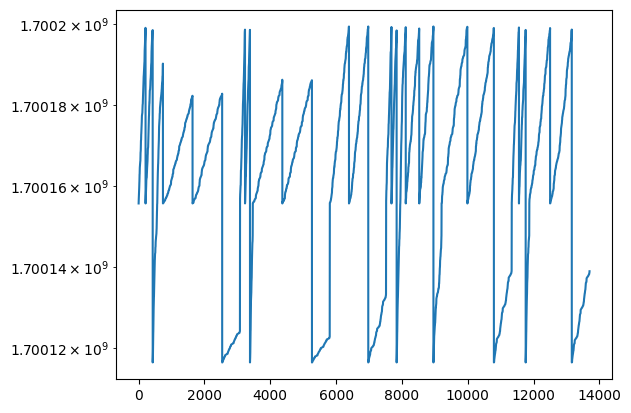

In [29]:
sns.lineplot(x=range(len(df["start_time"])), y=df["start_time"].values)
plt.yscale("log")

In [30]:
print(len(set(df["qname"])))

180


In [31]:
tmp = df[df["qname"] == "8a.sql"]
tmp[["relative_start_time", "qname", "runtime"]]

,relative_start_time,qname,runtime


In [32]:
# tmp1 = df[df["relative_start_time"] < 5800]
# tmp2 = df[df["relative_start_time"] >= 5800]
# tmp2 = tmp2[tmp2["relative_start_time"] < 8000]

<AxesSubplot: >

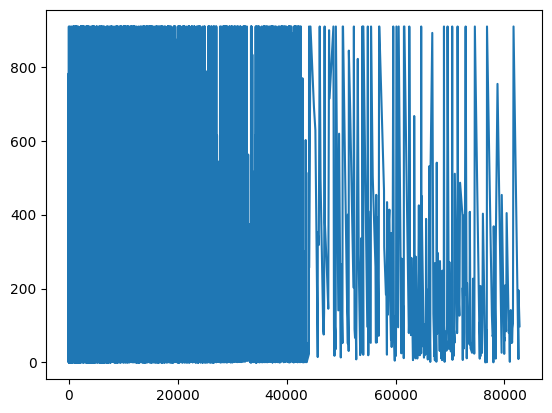

In [33]:
sns.lineplot(x=df["relative_start_time"].values, y=df["runtime"].values)

In [34]:
logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
list(logfns)

['/Users/pari/prism-testbed/LatencyCollectorResults/concurrent/exp5-stack-n2/i-0aecc0dc52d770d86/results/sar_logs.csv',
 '/Users/pari/prism-testbed/LatencyCollectorResults/concurrent/exp5-stack-n2/i-0aecc0dc52d770d86/results/sar_logs00',
 '/Users/pari/prism-testbed/LatencyCollectorResults/concurrent/exp5-stack-n2/i-0aecc0dc52d770d86/results/sar_logs07',
 '/Users/pari/prism-testbed/LatencyCollectorResults/concurrent/exp5-stack-n2/i-0aecc0dc52d770d86/results/sar_logs31',
 '/Users/pari/prism-testbed/LatencyCollectorResults/concurrent/exp5-stack-n2/i-0aecc0dc52d770d86/results/sar_logs36',
 '/Users/pari/prism-testbed/LatencyCollectorResults/concurrent/exp5-stack-n2/i-0aecc0dc52d770d86/results/sar_logs09',
 '/Users/pari/prism-testbed/LatencyCollectorResults/concurrent/exp5-stack-n2/i-0aecc0dc52d770d86/results/sar_logs37',
 '/Users/pari/prism-testbed/LatencyCollectorResults/concurrent/exp5-stack-n2/i-0aecc0dc52d770d86/results/sar_logs08',
 '/Users/pari/prism-testbed/LatencyCollectorResults/co

In [37]:

#logdfs = defaultdict(list)

all_logdfs = {}
for exp in EXP_NAMES:
    #resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "new", exp)
    resultdir = os.path.join("/Users/pari/prism-testbed/", "LatencyCollectorResults", "concurrent", exp)
    #logdfs = {}
    logfns = glob.iglob(resultdir + "/*/results/sar_logs*")
    #print(list(logfns))
    instance_dirs = os.listdir(resultdir)
    for iname in instance_dirs:
        if os.path.isdir(os.path.join(resultdir, iname)):
            all_logdfs[iname] = {}
        else:
            print(iname)
    
    ltdf = pd.read_csv(os.path.join(resultdir, LT_FN), header=None, 
           names=["instance", "lt"])
    ltdf = ltdf.merge(lt_types, on="lt")
    
    for fi, fn in enumerate(logfns):
        instance_name = os.path.basename(os.path.dirname(os.path.dirname(fn)))
        #print(instance_name)
        #all_logdfs[instance_name] = logdfs
        logdfs = all_logdfs[instance_name]

        if ".csv" in fn or "sar_logs00" in fn:
            continue
        try:
            curdf = pd.read_csv(fn, delimiter=";")
            #curdf["instance"] = instance_name
            #curdf = curdf.merge(ltdf, on="instance")
        except Exception as e:
            print("Exception@")
            print(e)
            continue

        if 'kbmemfree' in curdf.keys():
            logdfs["mem"] = curdf
        elif "dropd/s" in curdf.keys():
            logdfs["network1"] = curdf
        elif "%sio-10" in curdf.keys():
            #system load and pressure-stall statistics
            logdfs["pressure_io"] = curdf
        elif 'kbhugfree' in curdf.keys():
            logdfs["hugepg"] = curdf
        elif '%smem-10' in curdf.keys():
            logdfs["pressure_mem"] = curdf
        elif 'kbswpfree' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'idgm6/s' in curdf.keys():
            logdfs["network2"] = curdf
        elif 'bdscd/s' in curdf.keys():
            logdfs["io1"] = curdf
        elif '%irq' in curdf.keys():
            logdfs["cpu_utilization"] = curdf
        elif 'atmptf/s' in curdf.keys():
            logdfs["network3"] = curdf
        elif 'idgm/s' in curdf.keys():
            logdfs["network4"] = curdf
        elif 'areq-sz' in curdf.keys():
            logdfs["device_io"] = curdf
        elif 'call/s' in curdf.keys():
            logdfs["network_nfs"] = curdf
        elif 'rxdrop/s' in curdf.keys():
            logdfs["network5"] = curdf
        elif 'rxcmp/s' in curdf.keys():
            logdfs["network6"] = curdf
        elif 'tcp6sck' in curdf.keys():
            logdfs["network7"] = curdf
        elif 'iseg/s' in curdf.keys():
            logdfs["network8"] = curdf
        elif 'pswpin/s' in curdf.keys():
            logdfs["swap"] = curdf
        elif 'intr/s' in curdf.keys():
            logdfs["interrupts"] = curdf
        elif '%scpu-10' in curdf.keys():
            logdfs["pressure_cpu"] = curdf
        elif 'MHz' in curdf.keys():
            logdfs["power-cpu"] = curdf
        elif 'degC' in curdf.keys():
            logdfs["power-temp"] = curdf
        elif '%ufsused' in curdf.keys():
            logdfs["filesystem"] = curdf
        elif 'cswch/s' in curdf.keys():
            logdfs["context_switch"] = curdf
        elif 'pgpgin/s' in curdf.keys():
            logdfs["paging"] = curdf
        elif 'fwddgm/s' in curdf.keys():
            logdfs["network9"] = curdf
        elif 'ihdrer6/s' in curdf.keys():
            logdfs["network10"] = curdf
        elif 'imsg/s' in curdf.keys():
            logdfs["network11"] = curdf
        elif 'ierr6/s' in curdf.keys():
            logdfs["network12"] = curdf
        elif 'scall/s' in curdf.keys():
            logdfs["network13"] = curdf
        elif 'runq-sz' in curdf.keys():
            logdfs["pressure_load"] = curdf
        elif 'dentunusd' in curdf.keys():
            logdfs["inode"] = curdf
        elif 'igmbq6/s' in curdf.keys():
            logdfs["network14"] = curdf
        elif 'tcpsck' in curdf.keys():
            logdfs["network15"] = curdf
        elif 'otmex/s' in curdf.keys():
            logdfs["network16"] = curdf
        elif 'ihdrerr/s' in curdf.keys():
            logdfs["network17"] = curdf
        elif 'irec6/s' in curdf.keys():
            logdfs["network18"] = curdf
        else:
            assert False

lt_instances.txt


In [38]:
print("Number of log files: ", len(logdfs))

todel = []
for instance,logdfs in all_logdfs.items():
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]
    if len(tmp) == 0:
        todel.append(instance)
        
for td in todel:
    del all_logdfs[td]

for instance,logdfs in all_logdfs.items():
    print(instance, len(logdfs))
    keys = list(logdfs.keys())
    tmp = df[df["instance"] == instance]

    min_qtime = min(tmp["start_time"].values)
    max_qtime = max(tmp["start_time"].values)

    for k in keys:
        if "network" in k:
            del logdfs[k]
            continue
        if "hugepg" in k:
            del logdfs[k]
            continue

        if len(logdfs[k]) == 0:
            continue

        mincur = min(logdfs[k]["timestamp"])
        logdfs[k]["relative_time"] = logdfs[k].apply(lambda x: x["timestamp"]-min_qtime , axis=1)
        logdfs[k] = logdfs[k][logdfs[k]["relative_time"] >= -10.0]
        
print("Number of log files w/o networking: ", len(logdfs))

Number of log files:  36
i-0aecc0dc52d770d86 36
i-0a7084c5afd7ef52e 36
i-055fa0868f0aa10a4 36
i-068901fa01dae9694 36
i-00b00c2a14b6b0f55 36
i-05ff7a181502041be 36
i-0917a6319051d3dde 36
i-0d81df58342c217df 36
i-0eb7399cd4953b27e 36
i-0f1027584f0d92e46 36
Number of log files w/o networking:  16


In [136]:
for instance,logdfs in all_logdfs.items():
    print(logdfs.keys())
    print(min(logdfs["mem"]["relative_time"]))

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-2.839749813079834
dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-5.3948280811309814
dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-3.045999526977539
dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])
-7.728352785110474
dict_keys(['mem', 'pressure_io', 'p

In [137]:
print(all_logdfs.keys())
print(set(df["instance"]))

dict_keys(['i-0606bfb433e5561f8', 'i-084d564f783af728b', 'i-0dea2030ca5c3294c', 'i-028a09789b16d9825', 'i-00cd9282e8375fc62', 'i-0544390bd3d5afa85', 'i-007676c1b1e47d2da', 'i-05a0c18d4422472ce', 'i-07728ca07f9aac62f', 'i-0e17cd470d89784cf', 'i-0d101b898c09b1946', 'i-01dad217f13526c56'])
{'i-07728ca07f9aac62f', 'i-0606bfb433e5561f8', 'i-0d101b898c09b1946', 'i-0544390bd3d5afa85', 'i-01dad217f13526c56', 'i-00cd9282e8375fc62', 'i-0e17cd470d89784cf', 'i-084d564f783af728b', 'i-028a09789b16d9825', 'i-05a0c18d4422472ce', 'i-0dea2030ca5c3294c', 'i-007676c1b1e47d2da'}


In [138]:
total = 0
for ldf in logdfs:
    print(ldf, logdfs[ldf].keys())
    total += len(logdfs[ldf].keys())

print("Num data points per timestamp: ", total)

mem Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused', 'relative_time'],
      dtype='object')
pressure_io Index(['# hostname', 'interval', 'timestamp', '%sio-10', '%sio-60', '%sio-300',
       '%sio', '%fio-10', '%fio-60', '%fio-300', '%fio', 'relative_time'],
      dtype='object')
pressure_mem Index(['# hostname', 'interval', 'timestamp', '%smem-10', '%smem-60',
       '%smem-300', '%smem', '%fmem-10', '%fmem-60', '%fmem-300', '%fmem',
       'relative_time'],
      dtype='object')
swap Index(['# hostname', 'interval', 'timestamp', 'pswpin/s', 'pswpout/s',
       'relative_time'],
      dtype='object')
io1 Index(['# hostname', 'interval', 'timestamp', 'tps', 'rtps', 'wtps', 'dtps',
       'bread/s', 'bwrtn/s', 'bdscd/s', 'relative_time'],
      dtype='object')
cpu_utilization Index([

# Interrupts / s

In [139]:
logdfs["interrupts"].groupby("INTR")["intr/s"].describe()

,count,mean,std,min,25%,50%,75%,max
INTR,,,,,,,,
-1,802.0,242.276197,57.165248,110.8,195.95,250.0,278.175,477.2
0,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
1,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
2,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
3,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
...,...,...,...,...,...,...,...,...
435,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
436,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0
437,802.0,0.000000,0.000000,0.0,0.00,0.0,0.000,0.0


# PageFaults / s

In [140]:
# pgdf = logdfs["paging"]
# sns.lineplot(x=pgdf["relative_time"], y=pgdf["fault/s"].values)

<AxesSubplot:>

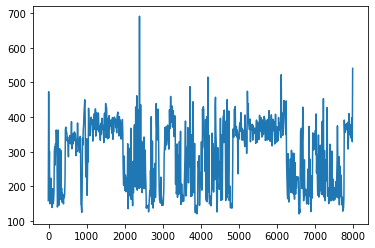

In [141]:
cdf = logdfs["context_switch"]
sns.lineplot(x=cdf["relative_time"].values, y=cdf["cswch/s"].values)

In [142]:
# powdf = logdfs["power-temp"]
# sns.lineplot(x=range(len(powdf)), y=powdf["degC"].values)

In [143]:
# powcpu = logdfs["power-cpu"]
# sns.lineplot(x=range(len(powcpu)), y=powcpu["MHz"].values)

In [144]:
pcpu = logdfs["pressure-cpu"]
sns.lineplot(x=pcpu["relative_time"].values, y=pcpu["%scpu"].values)

KeyError: 'pressure-cpu'

<AxesSubplot:xlabel='relative_time'>

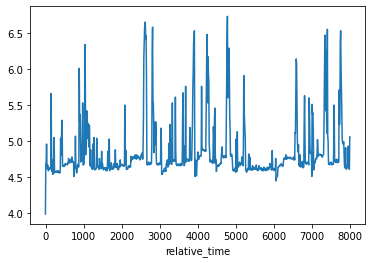

In [145]:
memdf = logdfs["mem"]
sns.lineplot(x=memdf["relative_time"], y=memdf["%memused"].values)

In [146]:
logdfs.keys()

dict_keys(['mem', 'pressure_io', 'pressure_mem', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure_cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure_load', 'inode'])

<AxesSubplot:xlabel='relative_start_time', ylabel='runtime'>

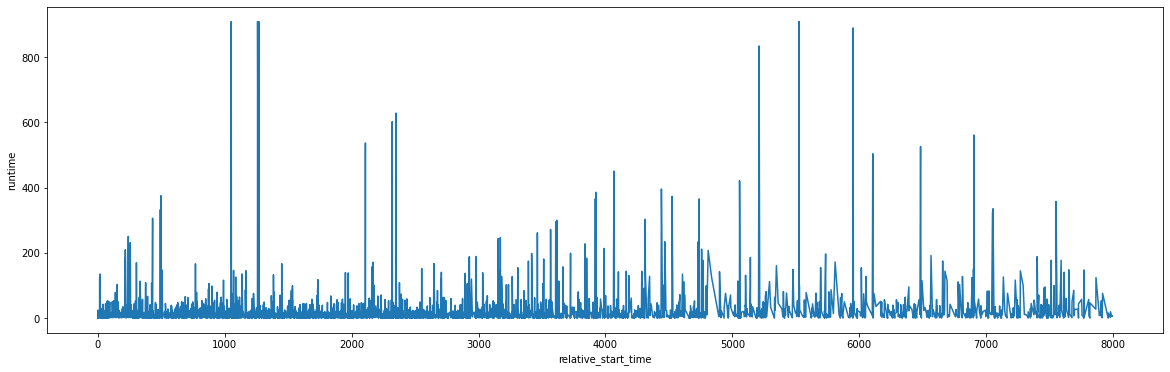

In [147]:
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
sns.lineplot(data=df, x="relative_start_time", y = "runtime", ax=axs)

In [148]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.lineplot(data=tmp, x="relative_start_time", y = "runtime", ax=axs)

In [149]:
# tmp = df[df["runtime"] <= 900.0]

# fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(20,6))
# sns.histplot(data=tmp, x="relative_start_time", y = "runtime", stat="count", bins=1000, ax=axs)

<AxesSubplot:xlabel='relative_start_time', ylabel='runtime'>

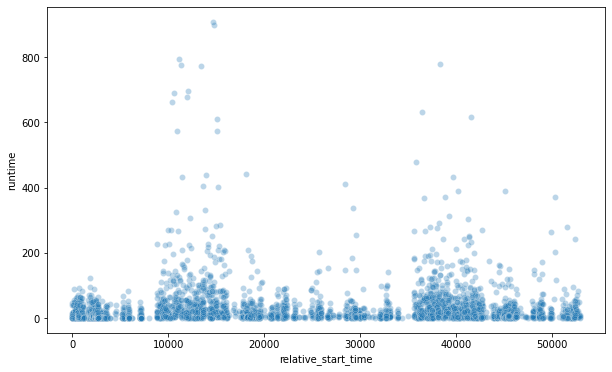

In [684]:
#tmp = df[df["runtime"] <= 900.0]

fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)


In [111]:
logdfs["device_io"].groupby(["DEV"])["areq-sz"].describe()

,count,mean,std,min,25%,50%,75%,max
DEV,,,,,,,,
loop0,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop1,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop2,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop3,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop4,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
loop5,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0
nvme0n1,2234.0,27.248133,46.340622,4.36,6.29,9.33,22.0,243.3
nvme0n1p1,2234.0,27.248133,46.340622,4.36,6.29,9.33,22.0,243.3
nvme0n1p15,2234.0,0.000000,0.000000,0.00,0.00,0.00,0.0,0.0


In [112]:
print(min(logdfs["paging"]["timestamp"].values), max(logdfs["paging"]["timestamp"].values))
mins = min(logdfs["paging"]["timestamp"].values)
maxs = max(logdfs["paging"]["timestamp"].values)

1677652496 1677674826


In [113]:
print(min(df["start_time"].values), max(df["start_time"].values))
mins2 = min(df["start_time"].values)
maxs2 = max(df["start_time"].values)

1677652495.8028135 1677674833.5794923


In [114]:
"Seconds after which we started executing queries: ", mins2 - mins

('Seconds after which we started executing queries: ', -0.19718647003173828)

In [115]:
"Seconds after which we finished executing queries: ", maxs - maxs2

('Seconds after which we finished executing queries: ', -7.5794923305511475)

In [116]:
"Seconds for total sys logging: ", maxs - mins

('Seconds for total sys logging: ', 22330)

In [117]:
"Seconds for total query executions: ", maxs2 - mins2

('Seconds for total query executions: ', 22337.776678800583)

In [118]:
print(len(set(df["qname"])))

146


In [119]:
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource
# from bokeh.plotting import figure

# output_notebook()
# # output_file('test.html')

# def get_dataset(src, key):
#     source = ColumnDataSource(data=src)
#     return source


# curdf = logdfs["mem"]
# cc = []
# for key in curdf.keys():
#     if key not in ["# hostname", "interval", "timestamp", "relative_time"]:
#         cc.append(key)

# sel = cc[0]
# # vselect = Select(value=ver, title='Statistic Name', options=sorted((cc)))
# # source = get_dataset(curdf, ver)

# plot = figure(plot_width=500, plot_height = 400, tools="", 
#               toolbar_location=None)
# plot.xaxis.axis_label = 'Unix Seconds'
# plot.yaxis.axis_label = 'Stats'
# plot.axis.axis_label_text_font_style = 'bold'

# plot.grid.grid_line_alpha = 0.3 
# plot.title.text = "System Statistics"

# lines = []
# for key in cc:
#     lines.append(plot.line(x='relative_time', y=key, source=source))
#     lines[-1].visible = False

# select = Select(title="Plot to show:", value=sel, options=cc)

# select.js_on_change("value", CustomJS(args=dict(lines=lines, options=cc), code="""
#     for (let i = 0, len = options.length; i < len; i++) {
#         if (this.value == options[i]) {
#             lines[i].visible = true
#         } else {
#             lines[i].visible = false
#         }
#     }
# """))

# layout = column(select, plot)
# show(layout)

# #show(column(controls, plot))

# Working code for bokeh

In [120]:
# import copy
# import pandas as pd
# from bokeh.io import curdoc, output_notebook, output_file
# from bokeh.layouts import row, column
# from bokeh.models import Select, DataRange1d, ColumnDataSource
# from bokeh.plotting import figure

# output_notebook()

# curdf = logdfs["mem"]
# cc = []
# for key in curdf.keys():
#     if key not in ["# hostname", "interval", "timestamp", "relative_time"]:
#         cc.append(key)

# sel = cc[0]

# src = copy.deepcopy(curdf)
# src["to_plot"] = src[sel]
# source = ColumnDataSource(data=src)

# plot = figure(plot_width=500, plot_height = 400, tools="", 
#               toolbar_location=None)
# plot.xaxis.axis_label = 'Unix Seconds'
# plot.yaxis.axis_label = 'Stats'
# plot.axis.axis_label_text_font_style = 'bold'

# plot.grid.grid_line_alpha = 0.3 
# plot.title.text = "System Statistics"

# plot.line(x='relative_time', y="to_plot", source=source)

# select = Select(title="Statistic", value=sel, options=cc)
# select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
#     source.data["to_plot"] = source.data[this.value];
#     source.change.emit()
# """))

# # fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
# # sns.scatterplot(data=df, x="relative_start_time", y = "runtime", ax=ax, alpha=0.3)

# layout = column(select, plot)
# show(layout)

# # output_file('test.html')

In [1]:
import copy
import pandas as pd
from bokeh.io import curdoc, output_notebook, output_file
from bokeh.layouts import row, column
from bokeh.models import Select, DataRange1d, ColumnDataSource, MultiChoice
from bokeh.plotting import figure

def plot_all_instances(all_df):
    
    for instance in all_logdfs:
        
        curlogdfs = all_logdfs[instance]
        df = all_df[all_df["instance"] == instance]
        lttype = df["lt_type"].values[0]
        
        reset_output()
        output_file("Query-System-Logs-{}-{}.html".format(lttype, "imdb2"))

        KEY_ORDER = ["mem", "io1", "device_io", "cpu_utilization", 
                    "pressure_mem", "pressure_io", "pressure_cpu", "pressure_load",
                    "paging", "context_switch", 'interrupts', 'filesystem', 
                     'inode']

        def get_cur_plot(curdf, title, common_xrange, common_x):
            #global common_xrange, common_x

            cc = []
            for key in curdf.keys():
                if key not in ["# hostname", "interval", "timestamp", "relative_time", "DEV", 
                              "FILESYSTEM",]:
                    cc.append(key)

            sel = cc[0]
            src = curdf
            src = src.groupby("relative_time").mean().reset_index()
            src["to_plot"] = src[sel]

            source = ColumnDataSource(data=src)

            plot = figure(plot_width=420, plot_height = 400,
                          x_range = common_xrange,
                         )

            if common_xrange is None:
                common_xrange = plot.x_range
            else:
                source.data["common_relative_time"] = common_x

            plot.xaxis.axis_label = 'Seconds'
            plot.yaxis.axis_label = 'Stat'
            plot.axis.axis_label_text_font_style = 'bold'
            plot.grid.grid_line_alpha = 0.3 
            plot.title.text = title


            if common_x is None:
                plot.line(x='relative_time', y="to_plot", source=source)
                common_x = source.data["relative_time"]
                #common_x = source.data.relative_time
            else:
                plot.line(x="common_relative_time", y="to_plot", source=source)
                #plot.line(x=common_x, y=source.data["to_plot"])

            select = Select(title="Statistic", value=sel, options=cc)
            select.js_on_change("value", CustomJS(args=dict(source=source, select=select), code="""
                source.data["to_plot"] = source.data[this.value];
                source.change.emit()
            """))

            layout = column(select, plot)
            return layout, common_xrange, common_x

        circles = {}
        #df.groupby(["qname"])["runtime"].std().sort_values(by="std", ascending=False).head(60)
        tmp_std = df.groupby(["qname"])["runtime"].std().reset_index().rename(columns={"runtime":"std"})
        
        df = df.merge(tmp_std, on="qname")
        
        hover = HoverTool(tooltips=[
            ('qname', '@qname'),
            ('std', '@std'),
            ('relative_start_time', '@relative_start_time'),
            ('runtime', '@runtime'),
        ])
        
        
        runtime_plot = figure(title = "Query Runtimes", plot_width=1600, plot_height=400, tools=[hover])
        runtime_plot.xaxis.axis_label = 'Seconds'

        allqnames = list(set(df["qname"]))
        for qname in set(df["qname"]):
            tmp = df[df["qname"] == qname]
            rtsource = ColumnDataSource(data=tmp)
            c1 = runtime_plot.circle('relative_start_time','runtime', source=rtsource,
                                     fill_alpha=0.6, size=10)
            c1.visible = True
            circles[qname] = c1

        ### w/o separate circles for scatterplot
        # rtsource = ColumnDataSource(data=df)
        # runtime_plot.circle('relative_start_time','runtime', source=rtsource,fill_alpha=0.5, size=10)

        ### selection area
        multi_choice = MultiChoice(title="Query Selector", value=["all"], options=allqnames + ["all"])
        multi_choice.js_on_change("value", CustomJS(args=dict(circles=circles), code="""
            for (const [key, c1] of Object.entries(circles)) {
                if (this.value.includes("all")) {
                    c1.visible = true
                } else if (this.value.includes(key)) {
                    c1.visible = true
                } else {
                    c1.visible = false
                }
            }
        """))

        plots = []
        
        common_xrange = None
        common_x = None
        
        for key in KEY_ORDER:
            if len(logdfs[key]) == 0:
                continue
            if key in ["swap", "temp"]:
                continue
            p1,common_xrange,common_x = get_cur_plot(curlogdfs[key], key, common_xrange, common_x)
            plots.append(p1)

        show(column(column(multi_choice, runtime_plot), row(plots[0:4]), row(plots[4:8]), row(plots[8:12]), 
                    row(plots[12:16])))
        
plot_all_instances(df)

NameError: name 'df' is not defined

In [249]:
print(len(all_logdfs.keys()))

12


# Per query plots

In [453]:
reset_output()
output_notebook()

reset_output()
#output_notebook()

FN_TMP = "./{EXP_NAME}/{QNAME}.html"
TITLE_FMT = "{QUERY}.\n Start:{START}.\n Latency:{LAT}."
COLS = 2

make_dir(EXP_NAME)

plot_data = {}

for qi, qname in enumerate(list(set(df["qname"]))):
#     if qi >= 2:
#         break
    
    fn = FN_TMP.format(EXP_NAME=EXP_NAME, QNAME=qname.replace(".sql", ""))
    output_file(fn)
    print(fn)
    
    tmp = df[df["qname"] == qname]
    tmp = tmp.sort_values(by="relative_start_time")
    allplots = []
    
    for ei, exp in enumerate(tmp["exp_analyze"].values):
        try:
            plan = eval(str(exp))
            #print(plan)
        except Exception as e:
            print(e)
            continue
        
        lat = tmp["runtime"].values[ei]
        stime = tmp["relative_start_time"].values[ei]
        title = TITLE_FMT.format(QUERY=qname, START=stime, LAT = lat)

        G = explain_to_nx(plan[0][0][0])
        #print(len(G.nodes()))
        aliases = extract_values(plan[0][0][0], "Alias")
        #print(aliases)

        p1 = bokeh_plot(G, showplot=False,  height=600, width=800, title=title)
        p1.visible = True
        allplots.append(p1)
        
    allrows = []
    num_rows = math.ceil(len(allplots) / COLS)
    
    for i in range(num_rows):
        allrows.append(row(allplots[i*COLS:i*COLS+COLS]))
    
    save(column(allrows))
    #show(column(row(allplots[0:3]), row(allplots[3:6]), row(allplots[6:9])))

Loading BokehJS ...

./t7xlarge-gp3-d/29c.html
./t7xlarge-gp3-d/25b.html
./t7xlarge-gp3-d/23a.html
./t7xlarge-gp3-d/2a714.html
./t7xlarge-gp3-d/6de21f7b6d08d84073c7496dbff73afba95d7c8d.html
./t7xlarge-gp3-d/30b.html
./t7xlarge-gp3-d/18a.html
./t7xlarge-gp3-d/11d.html
./t7xlarge-gp3-d/26b.html
./t7xlarge-gp3-d/24b.html
./t7xlarge-gp3-d/4a143.html
./t7xlarge-gp3-d/32b1cf5e7af7bd6231e2d73a1b56ecf21bbd9804.html
./t7xlarge-gp3-d/3a76.html
./t7xlarge-gp3-d/7a58.html
./t7xlarge-gp3-d/29a.html
./t7xlarge-gp3-d/7045b4dac1171674c69f224b25c3c73ad8d9ca03.html
./t7xlarge-gp3-d/19a.html
./t7xlarge-gp3-d/408f3f94c386672c03af6b01705edab10554bba2.html
./t7xlarge-gp3-d/1a972.html
./t7xlarge-gp3-d/3a315.html
./t7xlarge-gp3-d/1c.html
./t7xlarge-gp3-d/16d.html
./t7xlarge-gp3-d/2c99.html
./t7xlarge-gp3-d/32a.html
./t7xlarge-gp3-d/5b.html
./t7xlarge-gp3-d/8c.html
./t7xlarge-gp3-d/be5f621ca67267a999a86e6b9843728d6992d649.html
./t7xlarge-gp3-d/2a620.html
./t7xlarge-gp3-d/3ebf44254fc9a2ae77481169131fd0ab111a6c43.html
./t7xlarge-gp3

./t7xlarge-gp3-d/20a.html
./t7xlarge-gp3-d/8a400.html
./t7xlarge-gp3-d/2a245.html
./t7xlarge-gp3-d/8d.html
./t7xlarge-gp3-d/30c.html
./t7xlarge-gp3-d/6a508.html
./t7xlarge-gp3-d/15d.html
./t7xlarge-gp3-d/728f1ee9b87457c8b28490639330db5b8f5b1e1c.html
./t7xlarge-gp3-d/6a338.html
./t7xlarge-gp3-d/61959f7b7fcd01bb21afed4e91a731fb1e4f5a14.html
./t7xlarge-gp3-d/1a761.html
./t7xlarge-gp3-d/1a1974.html
./t7xlarge-gp3-d/e8c1806d3f6d16369058ed9c40cc6b4e2e56676e.html
./t7xlarge-gp3-d/2a348.html
./t7xlarge-gp3-d/cd252c4d15a8d118c1aae28bd1ec48c7f45584b2.html
./t7xlarge-gp3-d/14a.html
./t7xlarge-gp3-d/2c192.html
./t7xlarge-gp3-d/5a686.html
./t7xlarge-gp3-d/7a160.html


In [321]:
src.groupby("relative_time").mean().reset_index()

,relative_time,timestamp
0,0,1674686716
1,10,1674686726
2,20,1674686736
3,30,1674686746
4,40,1674686756
...,...,...
2280,22810,1674709526
2281,22820,1674709536
2282,22830,1674709546
2283,22840,1674709556


In [116]:
print(logdfs.keys())
print(len(logdfs.keys()))

dict_keys(['mem', 'pressure1', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])
16


In [644]:
logdfs["mem"].keys()

Index(['# hostname', 'interval', 'timestamp', 'kbmemfree', 'kbavail',
       'kbmemused', '%memused', 'kbbuffers', 'kbcached', 'kbcommit', '%commit',
       'kbactive', 'kbinact', 'kbdirty', 'kbanonpg', 'kbslab', 'kbkstack',
       'kbpgtbl', 'kbvmused'],
      dtype='object')

In [643]:
logdfs.keys()

dict_keys(['mem', 'pressure1', 'hugepg', 'pressure2', 'swap', 'io1', 'cpu_utilization', 'device_io', 'interrupts', 'pressure-cpu', 'power-cpu', 'power-temp', 'filesystem', 'context_switch', 'paging', 'pressure-load', 'inode'])